In [1]:
import pandas as pd
import optuna

import pickle

import warnings
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score


from src.utils import pre_processing, FEATURES
from src.utils import plot_confusion_matrix, print_metrics

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Loan_Default.csv')

In [3]:
df = pre_processing(df[FEATURES], fill_na=True)

In [4]:
y = df['Status']

X = df.drop(columns=['Status'])

In [5]:
from imblearn.over_sampling import SMOTE
# Initialize the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=69)

# Generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=69, stratify=y_resampled)

In [7]:
y_hat = {}

#### K-means Clustering

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_resampled)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

In [10]:
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(data_scaled)

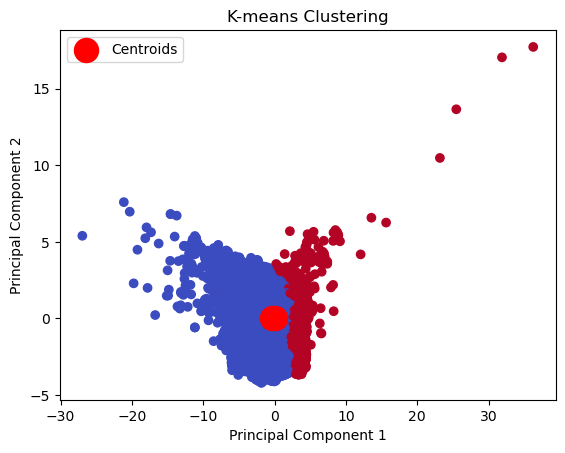

In [11]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#### Linear Discriminant Analysis

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [13]:
def objective(trial):
    # Hyperparameters to be tuned
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    # Only suggest shrinkage if solver is not 'svd'
    shrinkage = trial.suggest_float('shrinkage', 0.0, 1.0) if solver != 'svd' else None

    # Model training
    model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-10 13:35:34,065] A new study created in memory with name: no-name-53e19fe0-d2dc-444d-b78e-ec915fe78bcd
[I 2023-11-10 13:35:34,670] Trial 0 finished with value: 0.812159159765704 and parameters: {'solver': 'lsqr', 'shrinkage': 0.8934652504988974}. Best is trial 0 with value: 0.812159159765704.
[I 2023-11-10 13:35:35,235] Trial 1 finished with value: 0.8095515919319888 and parameters: {'solver': 'lsqr', 'shrinkage': 0.6694393180722757}. Best is trial 0 with value: 0.812159159765704.
[I 2023-11-10 13:35:36,284] Trial 2 finished with value: 0.7714425064449452 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.812159159765704.
[I 2023-11-10 13:35:36,858] Trial 3 finished with value: 0.7976997682602353 and parameters: {'solver': 'lsqr', 'shrinkage': 0.4979497208742363}. Best is trial 0 with value: 0.812159159765704.
[I 2023-11-10 13:35:37,433] Trial 4 finished with value: 0.8021672155529587 and parameters: {'solver': 'lsqr', 'shrinkage': 0.5506305843436963}. Best is 

In [14]:
lda = LinearDiscriminantAnalysis(solver=best_params['solver'], shrinkage=best_params['shrinkage'])
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Test F1 Score:", test_f1_score)

Best Hyperparameters: {'solver': 'eigen', 'shrinkage': 0.7890817582612089}
Test F1 Score: 0.8145479850181133


In [15]:
pickle.dump(lda, open('models/linear_discriminant_analysis.pkl', 'wb'))

In [16]:
print_metrics(y_test, y_pred)

Accuracy: 0.8025667843291062
*********************
Precision: 0.7679453535041679
*********************
Recall: 0.8671721793698522
*********************
F1-Score: 0.8145479850181133


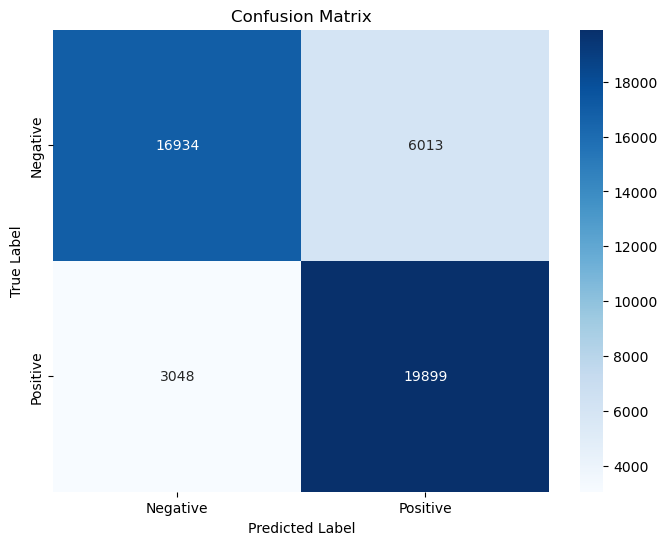

In [17]:
plot_confusion_matrix(y_test, y_pred)

In [18]:
y_hat['lda'] = y_pred

#### Qudratic Discriminant Analysis

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [20]:
def objective(trial):
    reg_param = trial.suggest_float('reg_param', 0.0, 1.0)

    model = QuadraticDiscriminantAnalysis(reg_param=reg_param)
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-10 13:36:39,995] A new study created in memory with name: no-name-f8858a50-e51c-4a93-8e9d-7ec9bbe76842
[I 2023-11-10 13:36:40,528] Trial 0 finished with value: 0.8145479850181133 and parameters: {'reg_param': 0.8355099407110238}. Best is trial 0 with value: 0.8145479850181133.
[I 2023-11-10 13:36:41,047] Trial 1 finished with value: 0.8145479850181133 and parameters: {'reg_param': 0.8934084992859782}. Best is trial 0 with value: 0.8145479850181133.
[I 2023-11-10 13:36:41,565] Trial 2 finished with value: 0.8145479850181133 and parameters: {'reg_param': 0.30412521873803133}. Best is trial 0 with value: 0.8145479850181133.
[I 2023-11-10 13:36:42,077] Trial 3 finished with value: 0.8145479850181133 and parameters: {'reg_param': 0.6760305739769833}. Best is trial 0 with value: 0.8145479850181133.
[I 2023-11-10 13:36:42,595] Trial 4 finished with value: 0.8145479850181133 and parameters: {'reg_param': 0.9717678717282693}. Best is trial 0 with value: 0.8145479850181133.
[I 2023-11

In [21]:
qda = QuadraticDiscriminantAnalysis(**best_params)
qda.fit(X_train, y_train)

y_pred = qda.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Test F1 Score:", test_f1_score)

Best Hyperparameters: {'reg_param': 0.8355099407110238}
Test F1 Score: 0.8277139824375183


In [22]:
pickle.dump(qda, open('models/qudratic_discriminant_analysis.pkl', 'wb'))

In [23]:
print_metrics(y_test, y_pred)

Accuracy: 0.8054865559768162
*********************
Precision: 0.7428294305112928
*********************
Recall: 0.9345012419924174
*********************
F1-Score: 0.8277139824375183


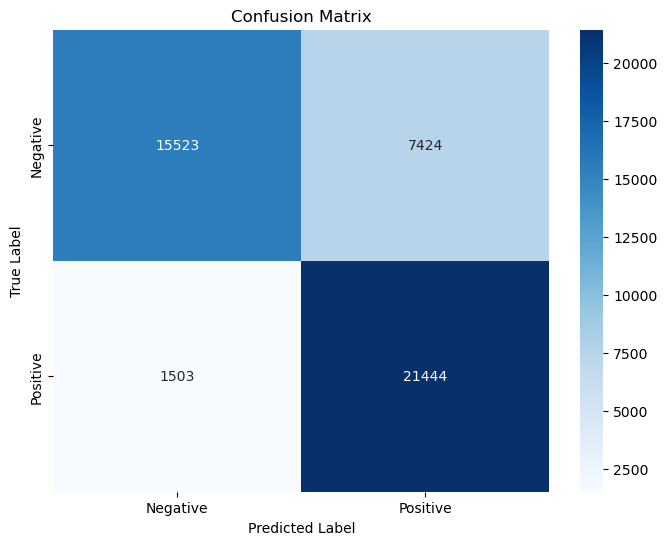

In [24]:
plot_confusion_matrix(y_test, y_pred)

In [25]:
y_hat['qda'] = y_pred

#### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = LogisticRegression(C=C,class_weight=class_weight ,max_iter=10000, random_state=69)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-10 13:37:32,297] A new study created in memory with name: no-name-26f7d925-1565-424d-8048-f33c271be8f6
[I 2023-11-10 13:37:35,384] Trial 0 finished with value: 0.7892064347982384 and parameters: {'C': 0.009122601633752359, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7892064347982384.
[I 2023-11-10 13:37:35,687] Trial 1 finished with value: 0.810994616038538 and parameters: {'C': 1.4115509482942676e-05, 'class_weight': None}. Best is trial 1 with value: 0.810994616038538.
[I 2023-11-10 13:37:36,715] Trial 2 finished with value: 0.7939102846567375 and parameters: {'C': 0.0008498927019705356, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.810994616038538.
[I 2023-11-10 13:37:44,723] Trial 3 finished with value: 0.7895816890292029 and parameters: {'C': 0.10795747672394933, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.810994616038538.
[I 2023-11-10 13:37:45,064] Trial 4 finished with value: 0.8120377143786068 and parameters: {'C': 1.915878

In [28]:
log_reg = LogisticRegression(C=best_params['C'], class_weight=best_params['class_weight'], max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Test F1 Score:", test_f1_score)

Best Hyperparameters: {'C': 3.576533860819369e-05, 'class_weight': None}
Test F1 Score: 0.8125000000000001


In [29]:
pickle.dump(log_reg, open('models/logistic_regression.pkl', 'wb'))

In [30]:
print_metrics(y_test, y_pred)

Accuracy: 0.8011504771865603
*********************
Precision: 0.7686297376093294
*********************
Recall: 0.8616812655249052
*********************
F1-Score: 0.8125000000000001


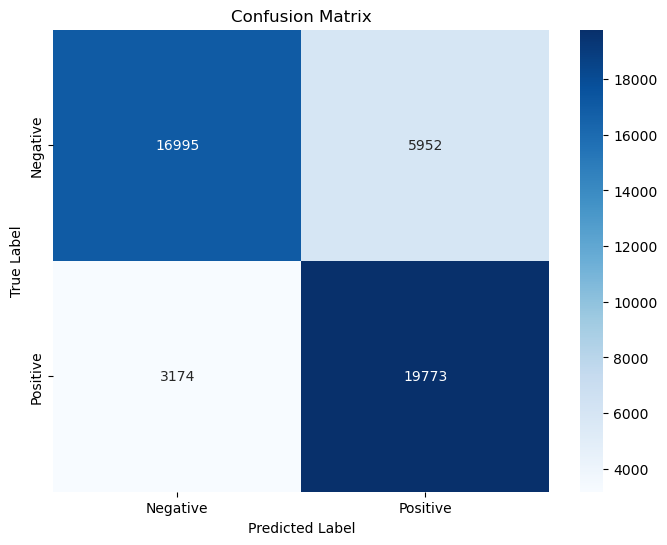

In [31]:
plot_confusion_matrix(y_test, y_pred)

In [32]:
y_hat['log_reg'] = y_pred

#### K-Nearest Neighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
def objective(trial):

    n_neighbors = trial.suggest_int("n_neighbors", 2, 15)

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params

[I 2023-11-10 13:38:52,448] A new study created in memory with name: no-name-eb825e42-a7d5-47c5-9c40-6cc5fc95a32b
[I 2023-11-10 13:39:01,147] Trial 0 finished with value: 0.9313787173356823 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 0.9313787173356823.
[I 2023-11-10 13:39:09,612] Trial 1 finished with value: 0.9268302725850285 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.9313787173356823.
[I 2023-11-10 13:39:18,546] Trial 2 finished with value: 0.9216213978138456 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.9313787173356823.
[I 2023-11-10 13:39:28,121] Trial 3 finished with value: 0.9192676333251413 and parameters: {'n_neighbors': 11}. Best is trial 0 with value: 0.9313787173356823.
[I 2023-11-10 13:39:37,507] Trial 4 finished with value: 0.9268302725850285 and parameters: {'n_neighbors': 5}. Best is trial 0 with value: 0.9313787173356823.
[I 2023-11-10 13:39:47,163] Trial 5 finished with value: 0.9241472725033864 and para

In [35]:
best_params

{'n_neighbors': 2}

In [36]:
knn = KNeighborsClassifier(** best_params)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Test F1 Score:", test_f1_score)

Best Hyperparameters: {'n_neighbors': 2}
Test F1 Score: 0.9441595932612349


In [37]:
pickle.dump(knn, open('models/k_nearest_neighbors.pkl', 'wb'))

In [38]:
print_metrics(y_test, y_pred)

Accuracy: 0.9435220290234018
*********************
Precision: 0.9336202121767287
*********************
Recall: 0.9549396435263869
*********************
F1-Score: 0.9441595932612349


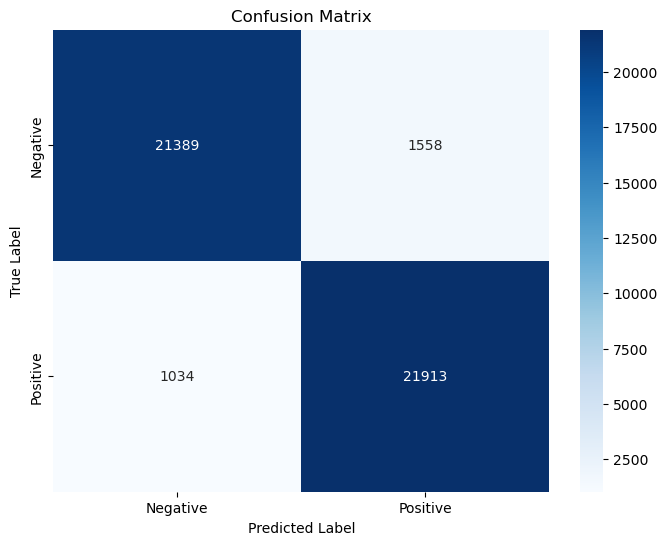

In [39]:
plot_confusion_matrix(y_test, y_pred)

In [40]:
y_hat['knn'] = y_pred

#### Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB

In [42]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Test F1 Score:", test_f1_score)

Test F1 Score: 0.6618302595926929


In [43]:
pickle.dump(naive_bayes, open('models/naive_bayes.pkl', 'wb'))

In [44]:
print_metrics(y_test, y_pred)

Accuracy: 0.7470911230226174
*********************
Precision: 0.9984177215189873
*********************
Recall: 0.49496666230879854
*********************
F1-Score: 0.6618302595926929


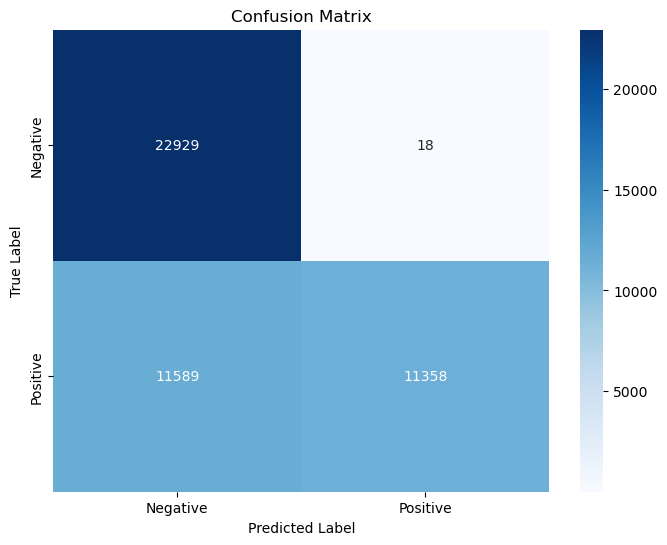

In [45]:
plot_confusion_matrix(y_test, y_pred)

In [46]:
y_hat['naive_bayes'] = y_pred

#### Decision Trees

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
def objective(trial):
    
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-10 13:41:14,064] A new study created in memory with name: no-name-2a165eac-5b07-4883-96a6-c014a38ec997
[I 2023-11-10 13:41:14,192] Trial 0 finished with value: 0.5677745982830729 and parameters: {'max_depth': 22, 'min_samples_split': 0.12447472821479563, 'min_samples_leaf': 0.48212241224942926}. Best is trial 0 with value: 0.5677745982830729.
[I 2023-11-10 13:41:14,311] Trial 1 finished with value: 0.6131478627625923 and parameters: {'max_depth': 23, 'min_samples_split': 0.535925863655888, 'min_samples_leaf': 0.4138896101782168}. Best is trial 1 with value: 0.6131478627625923.
[I 2023-11-10 13:41:14,431] Trial 2 finished with value: 0.6961139175052703 and parameters: {'max_depth': 18, 'min_samples_split': 0.7477024170862612, 'min_samples_leaf': 0.38899334376432726}. Best is trial 2 with value: 0.6961139175052703.
[I 2023-11-10 13:41:14,555] Trial 3 finished with value: 0.8658478890297674 and parameters: {'max_depth': 23, 'min_samples_split': 0.9699631122428323, 'min_samples_

In [49]:
d_tree = DecisionTreeClassifier(**best_params)
d_tree.fit(X_train, y_train)

y_pred = d_tree.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Test F1 Score:", test_f1_score)

Test F1 Score: 0.9973129437465866


In [50]:
pickle.dump(d_tree, open('models/decision_tree.pkl', 'wb'))

In [51]:
print_metrics(y_test, y_pred)

Accuracy: 0.9973199110994901
*********************
Precision: 0.9999123882950762
*********************
Recall: 0.9947269795615985
*********************
F1-Score: 0.9973129437465866


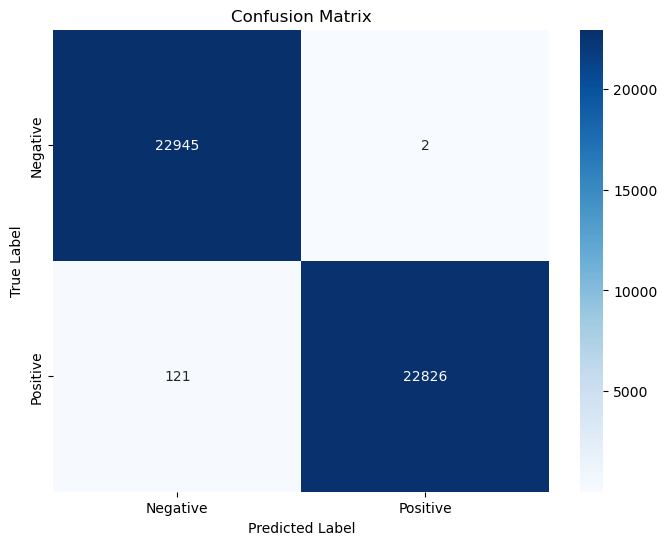

In [52]:
plot_confusion_matrix(y_test, y_pred)

In [53]:
y_hat['decision_trees'] = y_pred

#### Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 14)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 14)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params

[I 2023-11-10 13:41:37,965] A new study created in memory with name: no-name-05bf034a-5090-4cce-badc-226df63cc4ab
[I 2023-11-10 13:41:40,505] Trial 0 finished with value: 0.9500687127805773 and parameters: {'n_estimators': 92, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9500687127805773.
[I 2023-11-10 13:41:42,734] Trial 1 finished with value: 0.9587758173760348 and parameters: {'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9587758173760348.
[I 2023-11-10 13:41:47,625] Trial 2 finished with value: 0.9999564194195066 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9999564194195066.
[I 2023-11-10 13:41:50,987] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 13}. Best is trial 3 with value: 1.0.
[I 2023-1

In [56]:
rf_tree = RandomForestClassifier(**best_params)
rf_tree.fit(X_train, y_train)

y_pred = rf_tree.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Test F1 Score:", test_f1_score)

Test F1 Score: 0.9999782101845597


In [57]:
pickle.dump(rf_tree, open('models/random_forest.pkl', 'wb'))

In [58]:
print_metrics(y_test, y_pred)

Accuracy: 0.9999782106593454
*********************
Precision: 1.0
*********************
Recall: 0.9999564213186909
*********************
F1-Score: 0.9999782101845597


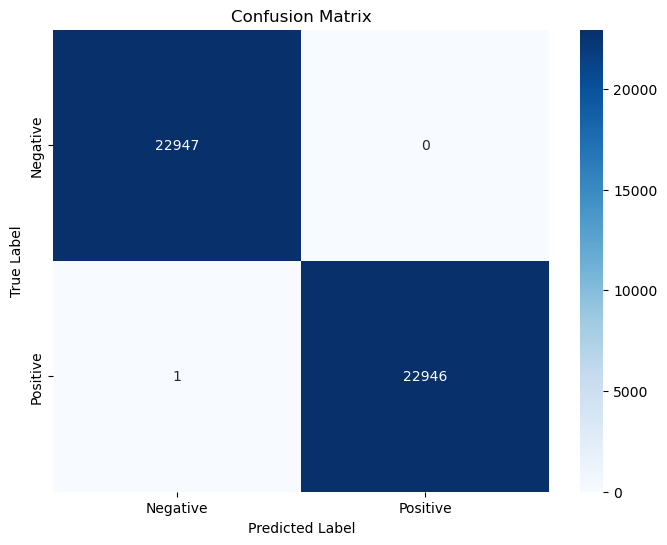

In [59]:
plot_confusion_matrix(y_test, y_pred)

In [60]:
y_hat['random_forest'] = y_pred

#### Ada Boost

In [61]:
from sklearn.ensemble import AdaBoostClassifier

In [62]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1)

    max_depth = trial.suggest_int("max_depth", 1, 10)

    base_estimator = DecisionTreeClassifier(max_depth=max_depth)

    model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params

[I 2023-11-10 13:42:58,050] A new study created in memory with name: no-name-d03b2c30-20e1-49ef-a15d-4a6c30c34d35
[I 2023-11-10 13:42:58,408] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 94, 'learning_rate': 0.4079673442637646, 'max_depth': 6}. Best is trial 0 with value: 1.0.
[I 2023-11-10 13:42:58,761] Trial 1 finished with value: 0.9999782101845597 and parameters: {'n_estimators': 19, 'learning_rate': 0.6085855535660585, 'max_depth': 9}. Best is trial 0 with value: 1.0.
[I 2023-11-10 13:42:59,117] Trial 2 finished with value: 0.9999782101845597 and parameters: {'n_estimators': 52, 'learning_rate': 0.7049916308463097, 'max_depth': 10}. Best is trial 0 with value: 1.0.
[I 2023-11-10 13:42:59,471] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 70, 'learning_rate': 0.354175336710612, 'max_depth': 9}. Best is trial 0 with value: 1.0.
[I 2023-11-10 13:43:07,307] Trial 4 finished with value: 0.9997820591055705 and parameters: {'n_estimators': 61, 'le

In [63]:
base_estimator = DecisionTreeClassifier(max_depth=best_params['max_depth'])
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'])
ada_boost.fit(X_train, y_train)

y_pred = ada_boost.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Test F1 Score:", test_f1_score)

Test F1 Score: 1.0


In [64]:
pickle.dump(ada_boost, open('models/ada_boost.pkl', 'wb'))

In [65]:
print_metrics(y_test, y_pred)

Accuracy: 1.0
*********************
Precision: 1.0
*********************
Recall: 1.0
*********************
F1-Score: 1.0


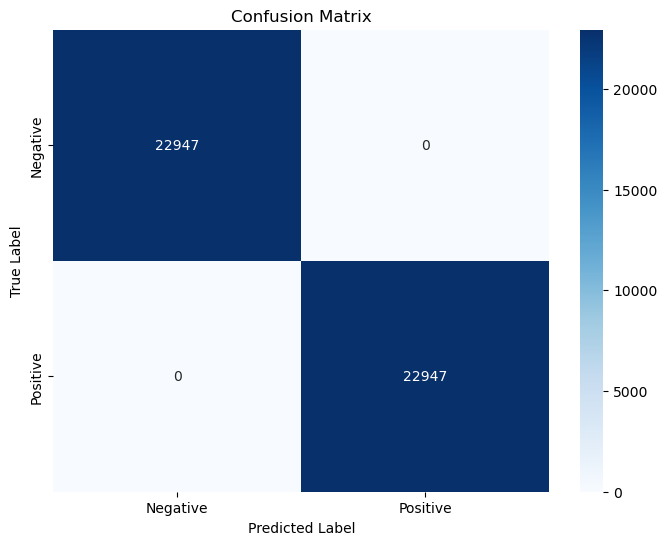

In [66]:
plot_confusion_matrix(y_test, y_pred)

In [67]:
y_hat['ada_boost'] = y_pred

### AUC-ROC curve

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

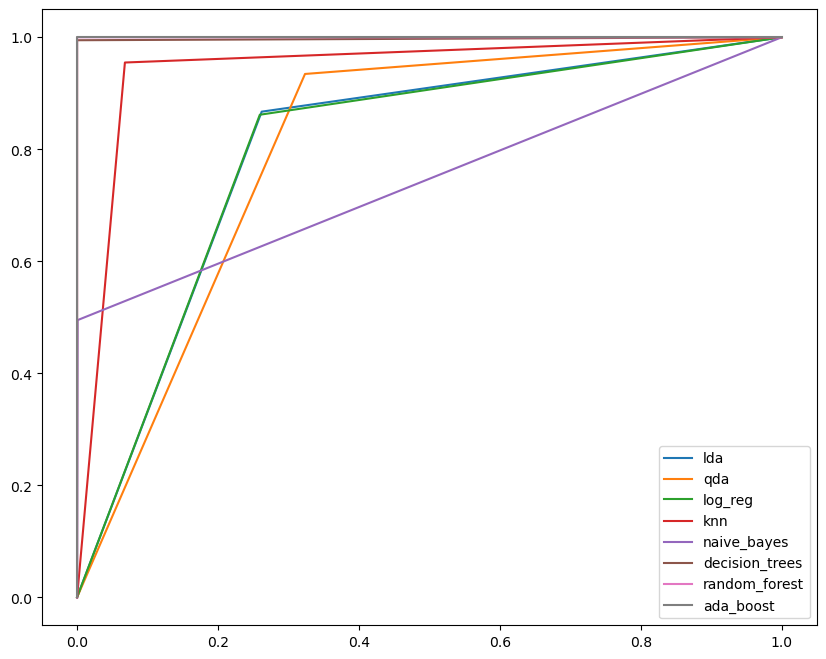

In [70]:
plt.figure(figsize=(10, 8))

for model_name, y_pred in y_hat.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.legend(y_hat.keys())

#### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    # Model definition
    model = SVC(C=C, kernel=kernel)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

best_params = study.best_params

In [ ]:
svm = SVC(**best_params)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print("Test F1 Score:", test_f1_score)

In [ ]:
pickle.dump(svm, open('models/support_vector_machine.pkl', 'wb'))

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
plot_confusion_matrix(y_test, y_pred)